In [65]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy.stats

import statsmodels.api as sm


%matplotlib inline

plt.rc('axes', labelsize=20) 
plt.rcParams["figure.figsize"] = (10,10)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13) 
mpl.rcParams['axes.titlesize'] = 24

In [3]:
election_results = pd.read_csv('data/processed_data/elections_camaras_municipais_portugal.csv')

In [4]:
# Get only relevant rows
data_on_ballot_order = election_results[
    (election_results.position_ballot.notnull()) & 
    (election_results.problems_ballot_order == False)
]

In [5]:
# Add column with the number of options in ballot
ballot_lengths = {}
for concelho in data_on_ballot_order.concelho.unique():
    ballot_length = data_on_ballot_order[data_on_ballot_order.concelho == concelho].position_ballot.max()
    ballot_lengths[concelho] = ballot_length
data_on_ballot_order['ballot_length'] = data_on_ballot_order.concelho.apply(lambda concelho: ballot_lengths[concelho])

/home/lcampos/Envs/local-elections-analysis/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
# Add column indicating if candidate is winner
winners_indexes = []
for concelho in data_on_ballot_order.concelho.unique():
    # Index of the candidate with most votes of this concelho
    index_winner = data_on_ballot_order[data_on_ballot_order.concelho == concelho].votes.argmax()
    winners_indexes.append(index_winner)
    

data_on_ballot_order['winner'] = data_on_ballot_order.apply(lambda candidate: candidate.name in winners_indexes, 1)

/home/lcampos/Envs/local-elections-analysis/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Check relation between ballot length and % votes. Intituition says that the longer the ballot, the less votes each party will have. Just a sanity check.

In [6]:
data_on_ballot_order.ballot_length.describe()

count    1311.000000
mean        4.736079
std         1.389350
min         2.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         9.000000
Name: ballot_length, dtype: float64

Correlation Cofficient: -0.290224866869
p-value: 7.34822752002e-27


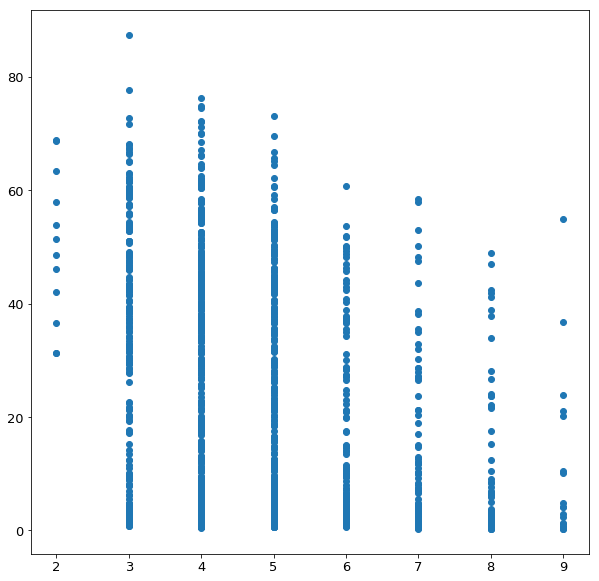

In [7]:
x = data_on_ballot_order.ballot_length
y = data_on_ballot_order['votes_%']

plt.scatter(x, y)

corr_cof, p_value = pearsonr(x, y)
print 'Correlation Cofficient: {}'.format(corr_cof)
print 'p-value: {}'.format(p_value)

# Check correlation between position in the ballot and percentage of votes.

Correlation Cofficient: -0.0861749146916
p-value: 0.00178997650752


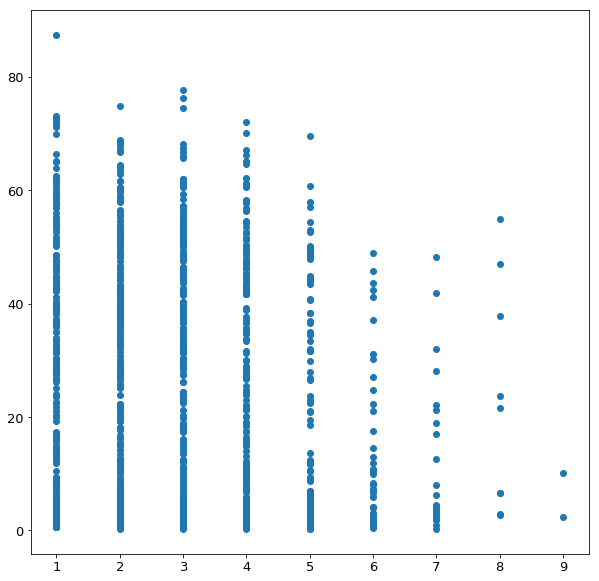

In [8]:
plt.scatter(data_on_ballot_order.position_ballot, data_on_ballot_order['votes_%'])

corr_cof, p_value = pearsonr(data_on_ballot_order.position_ballot, data_on_ballot_order['votes_%'])
print 'Correlation Cofficient: {}'.format(corr_cof)
print 'p-value: {}'.format(p_value)

### This direct correlation does not make sense, in light of knowing that in longer ballots each party receives less % of votes. Positions 1 and 2 in ballot always ocurr, in cases of smaller and longer ballots, on cases of both more and less diluted % of votes. More advanced positions ocur more rarely and when their ocurr the % of votes is more diluted. So it's expected that more advanced positions in ballot receive less votes, even whitout counting with voter's bias, if it exists. 

### Now I'll have to find a way to differentiate between the effect of the length of the ballot and voter bias. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                votes_%   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     9.794
Date:                Thu, 20 Apr 2017   Prob (F-statistic):            0.00179
Time:                        19:24:56   Log-Likelihood:                -5833.1
No. Observations:                1311   AIC:                         1.167e+04
Df Residuals:                    1309   BIC:                         1.168e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              26.1793      1.199     21.841      0.000      23.828      28.531
position_ballot    -1.1492      0.367     -3.129      0.002      -1.870      -0.429
==============================================================================
Omnibus:                      354.301   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.867
Skew:                           0.565   Prob(JB):                     7.68e-28
Kurtosis:                       1.995   Cond. No.                         7.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

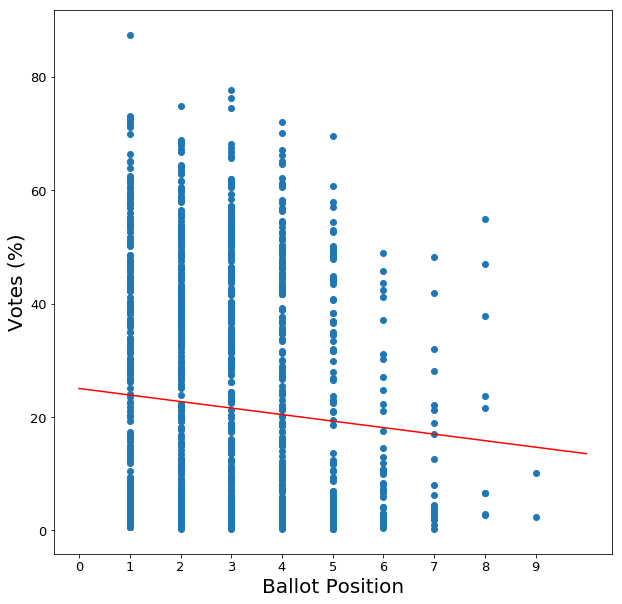

In [145]:
X = data_on_ballot_order.position_ballot
X = sm.add_constant(X)
y = data_on_ballot_order['votes_%']

model = sm.OLS(y, X)

est = model.fit()

const, position_ballot_coef = est.params

plt.scatter(X.position_ballot, y)
plt.xlabel('Ballot Position')
plt.ylabel('Votes (%)')
plt.xticks(np.arange(0, max(X.position_ballot)+1, 1.0))

regresssion_line = map(lambda x: position_ballot_coef * x + const, range(1,12))
plt.plot(regresssion_line, 'r')

est.summary()

In [147]:
# Consider ballot length

X = data_on_ballot_order[['position_ballot', 'ballot_length']]
X = sm.add_constant(X)
y = data_on_ballot_order['votes_%']

model = sm.OLS(y, X)

est = model.fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                votes_%   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     61.97
Date:                Thu, 20 Apr 2017   Prob (F-statistic):           1.94e-26
Time:                        19:35:53   Log-Likelihood:                -5778.7
No. Observations:                1311   AIC:                         1.156e+04
Df Residuals:                    1308   BIC:                         1.158e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              43.0937      1.962     21.967      0.000      39.245      46.942
position_ballot     0.7178      0.394      1.824      0.068      -0.054       1.490
ballot_length      -4.7020      0.442    -10.644      0.000      -5.569      -3.835
==============================================================================
Omnibus:                      291.844   Durbin-Watson:                   2.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.026
Skew:                           0.454   Prob(JB):                     8.53e-22
Kurtosis:                       2.025   Cond. No.                         21.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Check if candidates in first position tend to win more elections than expected if ballot order has no effect on voters decisions

In [7]:
def expected_observed_winners_nth_position(nth_position):
    
    counts_observed_winners_nth_positions = data_on_ballot_order[
        data_on_ballot_order.winner & 
        (data_on_ballot_order.position_ballot == nth_position) & 
        (data_on_ballot_order.ballot_length >= nth_position)
    ].ballot_length.value_counts()
    
    counts_observed_winners_nth_positions.name = 'observed_winners_in_nth_position'
    
    counts_ballot_length = data_on_ballot_order[data_on_ballot_order.ballot_length >= nth_position][['concelho', 'ballot_length']].drop_duplicates().ballot_length.value_counts()

    expected_observed_winners_nth_position_df = DataFrame()

    expected_observed_winners_nth_position_df['ballot_length'] = counts_ballot_length.index.sort_values()
    expected_observed_winners_nth_position_df.set_index(['ballot_length'], inplace=True)

    expected_observed_winners_nth_position_df['n'] = counts_ballot_length.sort_index().values
    expected_observed_winners_nth_position_df['expected_winners_in_nth_position'] = expected_observed_winners_nth_position_df['n'] / expected_observed_winners_nth_position_df.index
    expected_observed_winners_nth_position_df = expected_observed_winners_nth_position_df.join(counts_observed_winners_nth_positions)

    # If there were no winners in the nth position when there was a ballot length, use 0 instead of NA.
    expected_observed_winners_nth_position_df.observed_winners_in_nth_position = expected_observed_winners_nth_position_df.observed_winners_in_nth_position.fillna(0)
    
    return expected_observed_winners_nth_position_df

In [8]:
expected_observed_winners_nth_position(1)

,n,expected_winners_in_nth_position,observed_winners_in_nth_position
ballot_length,,,
2.0,6,3.000000,1.0
3.0,67,22.333333,25.0
4.0,112,28.000000,25.0
5.0,72,14.400000,7.0
6.0,22,3.666667,2.0
7.0,12,1.714286,4.0
8.0,7,0.875000,0.0
9.0,2,0.222222,0.0


In [52]:
"""Using model presented in "Meredith, M. & Salant, Y. Polit Behav (2013) 35: 175. doi:10.1007/s11109-011-9189-2" 
in section 'Results: Winning Elections and the Effect of Ballot Position'"""

# Null Hypothesis: Position in ballot has no effect in voters decisions

def get_test_statistics(ballot_position):

    candidates_nth_position = data_on_ballot_order[data_on_ballot_order.position_ballot == ballot_position]

    # This is the number of elections being studied
    t = len(candidates_nth_position)

    # How likely are the candidates in 1st position expected to win the election compared with what is expected if null hypothesis is true
    return candidates_nth_position.apply(lambda candidate_1st_position: (1 if candidate_1st_position.winner else 0) - (1/candidate_1st_position.ballot_length) , 1).sum() / t

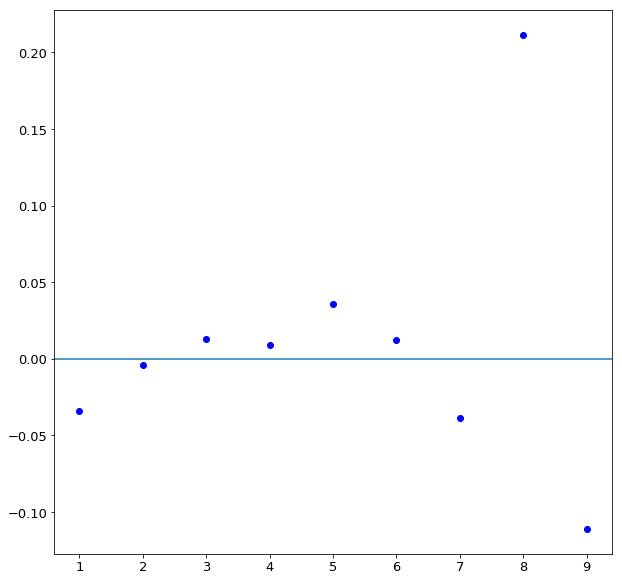

In [59]:
positions = data_on_ballot_order.position_ballot.unique()
test_statistics = map(lambda position: get_test_statistics(position), positions)
plt.plot(positions, test_statistics, 'bo')
plt.axhline(0)

In [60]:
# Percentage of times candidates listed first in the ballot are expected to win absent ballot order effects.
(candidates_1st_position.apply(lambda candidate_1st_position: 1 / candidate_1st_position.ballot_length, 1).sum() / t) * 100

24.221601338948275

In [152]:
# Percentage of times candidates listed first in the ballot are observed to win 
(candidates_1st_position.apply(lambda candidate_1st_position: (1 if candidate_1st_position.winner else 0), 1).sum() / float(t)) * 100

21.333333333333336

In [175]:
probability_null_hypothesis = 1 / candidates_1st_position.ballot_length
sd_distribution_test_statistics = (probability_null_hypothesis * (1 - probability_null_hypothesis)).sum() / (t**2)

In [183]:
scipy.stats.norm(0, sd_distribution_test_statistics)